# Preview

In this example, we are going to use our toolbox to train and evaluate the [Trajectory-based Dynamics Model](https://arxiv.org/abs/2012.09156) in the reacher environment. Note that the reacher environment in this repository is slightly different than the one used in that paper!

In [270]:
from IPython import display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf

import mbrl.env.pets_reacher as reacher_env
import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.util.common as common_util


%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating the environment

First we instantiate the environment.

In [271]:
seed = 0
env = reacher_env.Reacher3DEnv()
env.seed(seed)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape


# PID Agent

The following config object and the subsequent function call create an agent that can plan using the Cross-Entropy Method over the model environment created above. When calling `planning.create_trajectory_optim_agent_for_model`, we also specify how many particles to use when propagating model uncertainty, as well as the uncertainty propagation method, "fixed_model", which corresponds to the method TS$\infty$ in the PETS paper.

In [272]:
import numpy as np

from mbrl.planning import Agent


class PIDAgent(Agent):
    """
    Agent that reacts via an internal set of PID controllers.
    """

    def __init__(
        self,
        dim: int,
        Kp: np.ndarray,
        Ki: np.ndarray,
        Kd: np.ndarray,
        target: np.ndarray,
    ):
        """
        :param dim: dimensionality of state and control signal
        :param P: proportional control coeff
        :param I: integral control coeff
        :param D: derivative control coeff
        :param target: setpoint
        """
        super().__init__()
        assert len(Kp) == dim
        assert len(Ki) == dim
        assert len(Kd) == dim
        assert len(target) == dim

        self.n_dof = dim

        # TODO: add helper functions for setting and using state_mapping
        self.state_mapping = None   # can set to run PID on specific variables

        self.Kp = Kp 
        self.Ki = Ki 
        self.Kd = Kd 
        self.target = target
        self.prev_error = 0
        self.error = 0

    def act(self, obs: np.array) -> np.ndarray:
        if len(obs) > self.n_dof:
            obs = obs[:self.n_dof]
        q_des = self.target
        q = obs

        self.error = q_des - q
        P_value = self.Kp * self.error
        I_value = 0  # TODO: implement I and D part
        D_value = self.Kd * (self.error - self.prev_error)  
        self.prev_error = self.error
        action = P_value + I_value + D_value
        return action

    def _get_P(self):
        return self.Kp

    def _get_I(self):
        return self.Ki

    def _get_D(self):
        return self.Kd

    def _get_targets(self):
        return self.target

    def get_parameters(self):
        return np.stack((self._get_P(), self._get_I(), self._get_D(), self._get_targets())).flatten()


def create_pid_agent(action_dim):
    P = np.random.rand(action_dim) * 5
    I = np.zeros(action_dim)
    D = np.random.rand(action_dim)
    target = np.random.rand(action_dim) * 2 - 1

    agent = PIDAgent(dim=action_dim, Kp=P, Ki=I, Kd=D, target=target)
    return agent

In [273]:
agent = create_pid_agent(env.action_space.shape[0])

# Hydra configuration

MBRL-Lib uses [Hydra](https://github.com/facebookresearch/hydra) to manage configurations. For the purpose of this example, you can think of the configuration object as a dictionary with key/value pairs--and equivalent attributes--that specify the model and algorithmic options. Our toolbox expects the configuration object to be organized as follows:

In [274]:
trial_length = 500
num_trials = 10
ensemble_size = 5
# TODO add support for ensembles in sampling (below)
param_shape = (len(agent.get_parameters())+1,)

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": param_shape[0]+obs_shape[0], # control params, horizon, state_0
        "out_size": obs_shape[0],               # state time 0+h
        "deterministic": False,
        "propagation_method": "random_model",# NOTE not currently used (predicted in one forward pass, no re-samplign)
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": False, # trajectory based model predicts states directly
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 256,  # traj based model uses larger batch sizes
        "validation_ratio": 0.1
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

one_step_config_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
#         "propagation_method": "random_model",
        "propagation_method": "expectation",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True, 
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 40,
        "validation_ratio": 0.1
    }
}
one_step_config = omegaconf.OmegaConf.create(one_step_config_dict)

# Creating a dynamics model

Given the configuration above, the following two lines of code create a wrapper for 1-D transition reward models, and a gym-like environment that wraps it, which we can use for simulating the real environment. The 1-D model wrapper takes care of creating input/output data tensors to the underlying NN model (by concatenating observations, actions and rewards appropriately), normalizing the input data to the model, and other data processing tasks (e.g., converting observation targets to deltas with respect to the input observation).

In [275]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)


# Create replay buffers

We can create a replay buffer for this environment using an configuration a built-in method, where `collect_trajectories` is on for easier plotting of results.

Please note, we will create three replay buffers because our use-case pushes the limits of mbrl-lib. 
1. `replay_buffer_traj_train` is a replay buffer where will put all the sub-trajectories used to train the trajectory-based model,
2. `replay_buffer_traj_val` is a replay buffer storing trajectories with control parameters, used for plotting only.
3. `one_step_replay_buffer` is a replay buffer mirroring other examples in this library. We can use it for training and plotting one-step model results.

In [276]:
collect_full_trajectories = True
replay_buffer_traj_train = common_util.create_replay_buffer(cfg, 
                                                 obs_shape, 
                                                 param_shape, 
                                                 rng=np.random.default_rng(seed=0), 
                                                 collect_trajectories=False)

replay_buffer_traj_val = common_util.create_replay_buffer(cfg, 
                                                 obs_shape, 
                                                 param_shape, 
                                                 rng=np.random.default_rng(seed=0), 
                                                 collect_trajectories=True)

one_step_replay_buffer = common_util.create_replay_buffer(one_step_config, 
                                                          obs_shape, 
                                                          act_shape, 
                                                          rng=np.random.default_rng(seed=0), 
                                                          collect_trajectories=True)

We can now populate the replay buffer with random trajectories of a desired length, using a modified function based on `util.rollout_agent_trajectories`. The changes are that the tuples are only added to the buffer at the end of the trajectory to add every sub-trajectory for supervised learning.

In [277]:
trial = 0
while trial < num_trials:
    step = 0
    traj = []
    obs = env.reset()
    
    # create a new agent each trial to get a variety of PID parameters
    agent = create_pid_agent(env.action_space.shape[0])
    agent.reset()
    done = False
    while not done:
        action = agent.act(obs)
        next_obs, reward, done, info = env.step(action)
        
        # ADD ONE-STEP DATA
        one_step_replay_buffer.add(obs, action, next_obs, reward, done)

        # use a separate replay buffer for evaluating trajectories later (that can store trajectory info)
        replay_buffer_traj_val.add(obs, 
                                  np.concatenate((agent.get_parameters(), np.array([1,]))),
                                  next_obs,
                                  reward,
                                  done)

        
        obs = next_obs
        traj.append((obs, step))
        
        # ADD TRAJ-BASED DATA
        # if not the first step, iterate through memory and append each sub-trajectory
        if len(traj[:-1]) > 0:
            for obs_t, t in traj[:-1]:
#                 print(f"adding: mem time {t}, current time {step}, horizon {step-t}")
                replay_buffer_traj_train.add(obs_t, # obs is state_t
                                             # action is control params + hor
                                  np.concatenate((agent.get_parameters(), np.array([step-t,]))), 
                                  next_obs, # next state is state_t+hor
                                  reward, # reward not used
                                  done # done not used
                             )
        

        step += 1
                
        if trial_length and step % trial_length == 0:
            if collect_full_trajectories and not done:
                replay_buffer_traj_val.close_trajectory()
                one_step_replay_buffer.close_trajectory()
            break
    
#     print(f"Trajectory ran of length {step}")
    trial += 1    


# Training the Trajectory Based Model

Create a basic model trainer for our Gaussian MLP.

In [278]:
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-4, weight_decay=5e-5)

Create a training & validation dataset.

In [279]:
train_dataset, val_dataset = common_util.get_basic_buffer_iterators(
    replay_buffer_traj_train, 
    cfg.overrides.model_batch_size, 
    cfg.overrides.validation_ratio, 
    ensemble_size=ensemble_size, 
    shuffle_each_epoch=True
)

Train the model!

In [280]:
train_losses, val_losses = model_trainer.train(train_dataset, val_dataset, num_epochs=50, patience=100)

# Plotting Results

## Traj-based Model Loss

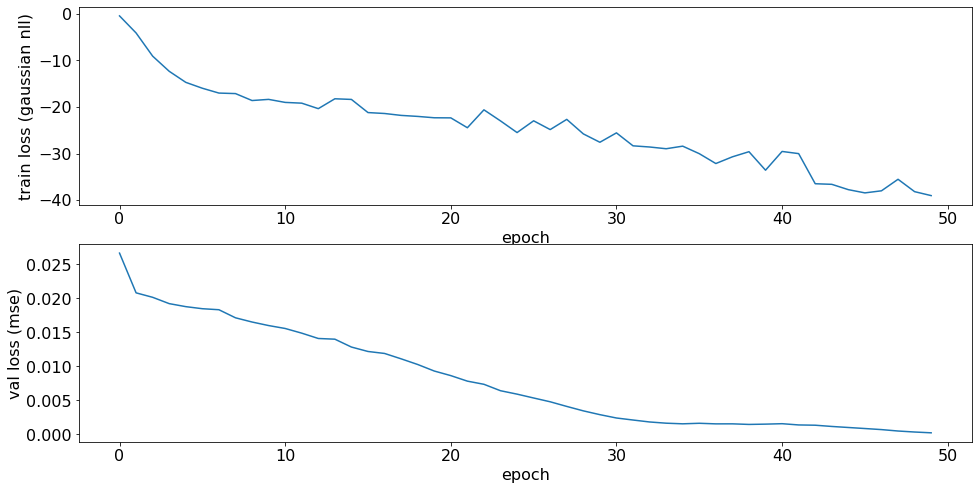

In [281]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(train_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train loss (gaussian nll)")
ax[1].plot(val_losses)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("val loss (mse)")
plt.show()

## Prediction Accuracy

Initialize an one-step model

In [282]:
# Create a 1-D dynamics model for this environment
one_step_model = common_util.create_one_dim_tr_model(one_step_config, obs_shape, act_shape)

# This functions allows the model to evaluate the true rewards given an observation 
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole

# Create a gym-like environment to encapsulate the model
one_step_model_env = models.ModelEnv(env, one_step_model, term_fn, reward_fn, generator=generator)

Train the one-step model

In [283]:
one_step_model_trainer = models.ModelTrainer(one_step_model, optim_lr=1e-4, weight_decay=5e-5)
one_step_train_dataset, one_step_val_dataset = common_util.get_basic_buffer_iterators(
    one_step_replay_buffer, #  
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size, 
    shuffle_each_epoch=True
)
one_step_train_losses, one_step_val_losses = one_step_model_trainer.train(one_step_train_dataset, one_step_val_dataset, 
                                               num_epochs=50, patience=100)

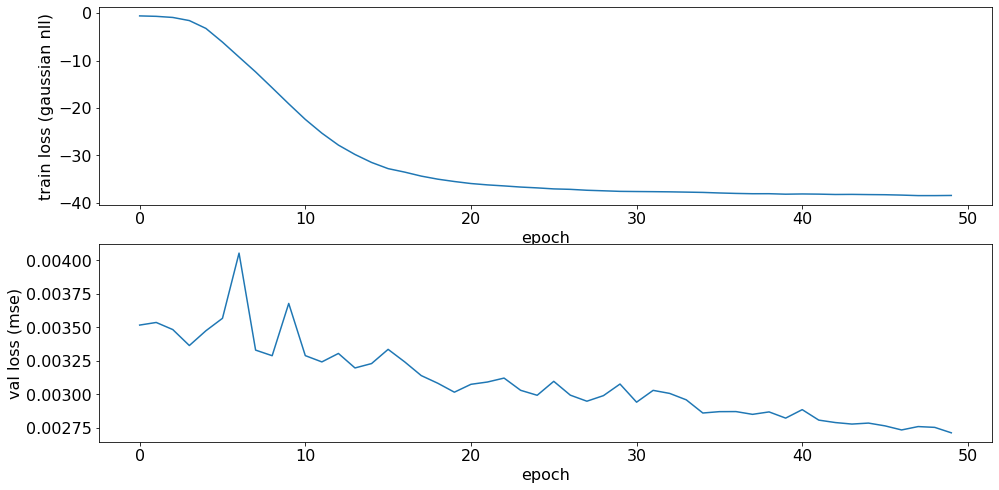

In [284]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(one_step_train_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train loss (gaussian nll)")
ax[1].plot(one_step_val_losses)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("val loss (mse)")
plt.show()

Sample trajectories for evaluation, predict trajectories, and compute MSE across states (without batching, does not work for ensemble).

In [285]:
# num_traj = 10
# eval_data = []
# one_step = []
# traj_based = []
# for i in range(num_traj):
#     traj = one_step_replay_buffer.sample_trajectory()
#     traj_with_params = replay_buffer_traj_val.sample_trajectory()
#     eval_data.append(traj)
    
#     ### rollout one-step model ###
#     states, _, _ = common_util.rollout_model_env(one_step_model_env, 
#                                      initial_obs=traj.obs[0],
#                                     plan=traj.act)
    
#     true_states = traj.obs
#     one_step_pred_states = states[:-1].squeeze()
#     one_step_errors = np.mean((true_states - one_step_pred_states)**2, axis=1)
#     one_step.append(one_step_errors)
    
#     ### rollout trajectory-based model ###
    
#     # set time indices
#     traj_with_params.act[:,-1] = np.arange(0,len(traj_with_params))+1

#     # construct batch
#     x_data = np.concatenate((traj_with_params.obs,traj_with_params.act), axis=1)
#     x_tensor = torch.from_numpy(x_data).float().to(device)
#     x_tensor = dynamics_model.input_normalizer.normalize(x_tensor)

#     with torch.no_grad():
#         states_pred, _ = dynamics_model(x_tensor)
    
#     traj_based_errors = np.mean((true_states - states_pred.numpy())**2, axis=1)
#     traj_based.append(traj_based_errors)
    
# cumulative_errors_os = np.stack(one_step)
# one_step_median = np.median(cumulative_errors_os,axis=0)

# cumulative_errors_tb = np.stack(traj_based)
# traj_based_median = np.median(cumulative_errors_tb,axis=0)

Predict trajectories with ensembles, needed correct batch size.

In [286]:
num_traj_eval = num_trials

# round trajectories to multiple of ensemble size for batching:
num_traj = int(ensemble_size * np.floor(num_traj_eval/ensemble_size))
eval_data_obs = []
eval_data_act = []
eval_traj_obs = []
eval_traj_param = []
one_step = []
traj_based = []
for i in range(num_traj):
    
    # base trajectory for computing accuracy
    traj = one_step_replay_buffer.sample_trajectory()
    
    # one-step data
    eval_data_obs.append(traj.obs)
    eval_data_act.append(traj.act)
    
    # traj-based data
    traj_with_params = replay_buffer_traj_val.sample_trajectory()
    traj_with_params.act[:,-1] = np.arange(0,len(traj_with_params))+1
    eval_traj_obs.append(traj.obs)
    eval_traj_param.append(traj_with_params.act)

    
### rollout one-step model in batch of trajectories ###
states, _, _ = common_util.rollout_model_env(one_step_model_env, 
                                 initial_obs=np.stack([o[0] for o in eval_data_obs],axis=0),
                                plan=np.stack(eval_data_act, axis=1))

true_states = np.stack(eval_data_obs)
one_step_pred_states = np.swapaxes(states[:-1].squeeze(),0,1)
one_step_errors = np.mean((true_states - one_step_pred_states)**2, axis=-1)
one_step.append(one_step_errors)
    
### rollout trajectory-based model in batch ###

# construct batch
x_data = np.concatenate((traj_with_params.obs,traj_with_params.act), axis=1)

obs_stack = np.stack([o[0] for o in eval_traj_obs])
param_stack = np.stack(eval_traj_param)

param_dim = np.shape(param_stack)[-1]
obs_dim = np.shape(obs_stack)[-1]
param_expand = param_stack.reshape(-1,param_dim)
obs_expand = np.repeat(obs_stack[:, np.newaxis, :], trial_length, axis=1).reshape(-1,obs_dim)

x_data = np.concatenate((obs_expand,param_expand), axis=1)
x_tensor = torch.from_numpy(x_data).float().to(device)
x_tensor = dynamics_model.input_normalizer.normalize(x_tensor)

with torch.no_grad():
    states_pred, _ = dynamics_model(x_tensor)

true_states = np.stack(eval_traj_obs)
states_pred = states_pred.numpy().reshape(num_traj, trial_length, -1)
traj_based_errors = np.mean((true_states - states_pred)**2, axis=-1)
traj_based.append(traj_based_errors)
    
cumulative_errors_os = np.stack(one_step).squeeze()
one_step_median = np.median(cumulative_errors_os,axis=0)

cumulative_errors_tb = np.stack(traj_based).squeeze()
traj_based_median = np.median(cumulative_errors_tb,axis=0)

In [287]:
param_dim = np.shape(param_stack)[-1]
obs_dim = np.shape(obs_stack)[-1]
param_stack =param_stack.reshape(-1,param_dim).shape
obs_expand = np.repeat(obs_stack[:, np.newaxis, :], trial_length, axis=1).reshape(-1,obs_dim)

obs_expand.shape
obs_stack
param_stack
# param_stack.shape

(5000, 29)

In [288]:
states_pred.shape
true_states.shape
((true_states - states_pred)**2).shape
one_step_pred_states.shape
traj_based_errors.shape

(10, 500)

## Trajectory-based vs One-step

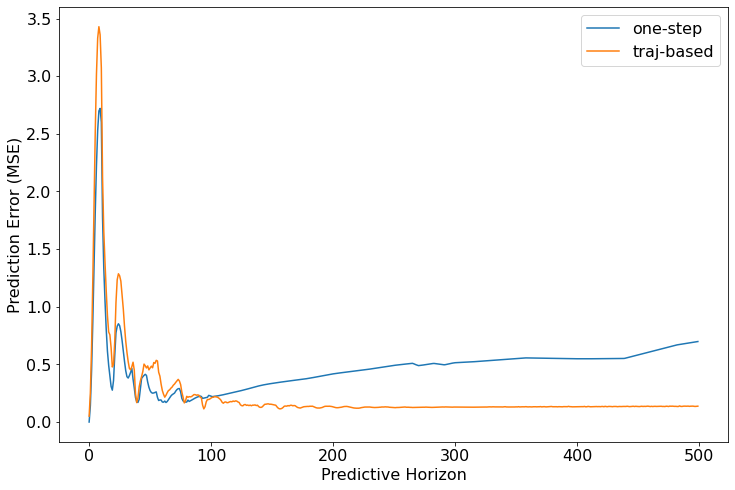

In [289]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(one_step_median, label="one-step")
ax.plot(traj_based_median, label="traj-based")
ax.set_xlabel("Predictive Horizon")
ax.set_ylabel("Prediction Error (MSE)")
ax.legend()
plt.show()